# Build Hotnet2 Network Container
In this notebook, I want to construct the network container for the Hotnet2 data. In order to do that, I have to do the following:
1. Construct a network from heat scores and edgelist (data in Hotnet2 github repo) or from network and mutation frequencies directly from TCGA.
2. Get labels (positive and negative) from OMIM
3. Do train/test split and save the whole thing


In [26]:
import pandas as pd
import numpy as np
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split

import mygene
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.associations import read_ncbi_gene2go
from goatools.go_search import GoSearch

%matplotlib inline

In [27]:
VAL_SIZE = 0
TEST_RATIO = 0.4
BALANCE = False
USE_HEAT_SCORES = False

## 1. Construct Network

In [29]:
# read edgelist and names
net_file = '../data/cancer/hotnet2/networks/irefindex9/irefindex9_edge_list'
name_file = '../data/cancer/hotnet2/networks/irefindex9/irefindex9_index_gene'
edgelist = pd.read_csv(net_file, sep=' ', header=None,
                       names=['from', 'to', 'weight'])
index = pd.read_csv(name_file, sep=' ', header=None, names=['name'])

# build network and relabel nodes to match with real names
G = nx.from_pandas_dataframe(edgelist, source='from', target='to', edge_attr=None)
print ("Edges: {}\tNodes: {}".format(G.number_of_edges(), G.number_of_nodes()))
_ = nx.relabel_nodes(G, index.to_dict()['name'], copy=False)

Edges: 91809	Nodes: 12129


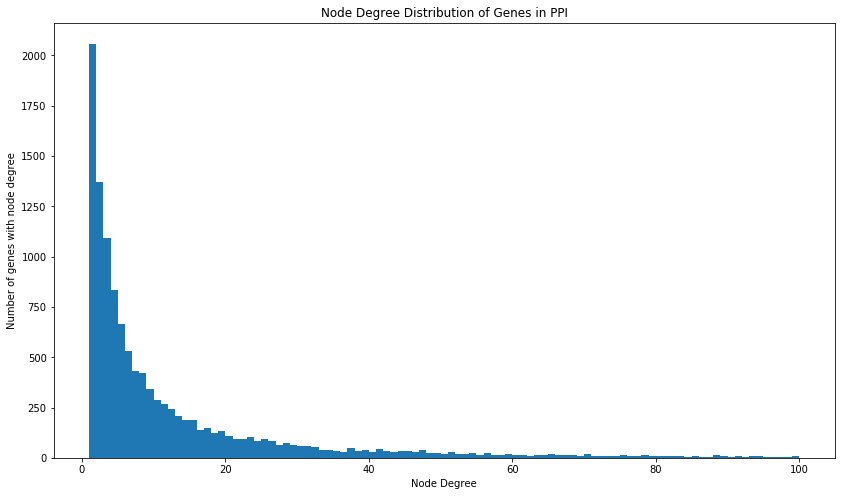

In [30]:
# plot node degree to check if distribution follows power law
node_degrees = np.array([i[1] for i in list(G.degree())])
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(1, 100, 100)
ax = plt.hist(node_degrees, bins)
plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution of Genes in PPI')

In [31]:
# self interactions?
assert (np.diag(nx.to_numpy_array(G)).sum() == 0)

In [33]:
# get edgelist with names from the networkx graph
l = nx.to_edgelist(G)
f = [i[0] for i in l]
t = [i[1] for i in l]
edges_names = pd.DataFrame(np.array([f, t]).T, columns=['from_node', 'to_node'])
node_list = pd.DataFrame(list(set().union(f, t)), columns=['name'])

# get features and see which ones are in the network

# get heat scores and see which ones are in our network
heat_file = '../data/cancer/hotnet2/heats/pan12.gene2freq.txt'
heat_scores = pd.read_csv(heat_file, header=None, sep=' ',
                          names=['gene_name', 'heat'], index_col=0)
nx.set_node_attributes(G, 0, name='heat')
nx.set_node_attributes(G, heat_scores.to_dict()['heat'], name='heat')
print ("# genes with heat scores: {}".format(len(heat_scores)))

# genes with heat scores: 11565


In [34]:
features = pd.read_csv('../data/cancer/TCGA/pancan12_rsem_matrix_tumor_type_means.tsv', sep='\t')
features.set_index('#Gene', inplace=True)
genes_with_features = features[features.index.isin(node_list.name)]
print ("# genes with gene expression: {}".format(genes_with_features.shape[0]))
default_val = np.zeros(12) # 12 different cancers
nx.set_node_attributes(G, default_val, 'features')
nx.set_node_attributes(G, genes_with_features.T.to_dict('list'), 'features')
assert (len(nx.get_node_attributes(G, 'features')) == len(G.nodes()))

# genes with gene expression: 8822


## 2. Network perturbations

In [15]:
def perturb_network(A, proportion_to_change):
    # calculate proportions
    to_keep = int(round(A.sum() * (1 - proportion_to_change)))
    to_add = int(round(A.sum() * proportion_to_change))

    # remove edges by building new graph with less edges
    row_idx, col_idx = np.where(A == 1) # all edge indices
    edges_to_keep = np.random.choice(np.indices(row_idx.shape)[0],
                                     size=to_keep,
                                     replace=False)
    A_perturbed = np.zeros_like(A)
    A_perturbed[row_idx[edges_to_keep], col_idx[edges_to_keep]] = 1
    
    # now, randomly add edges
    row_idx, col_idx = np.where(A_perturbed == 0) # possible edges to add
    edges_to_add = np.random.choice(np.indices(row_idx.shape)[0],
                                    size=to_add,
                                    replace=False)
    A_perturbed[row_idx[edges_to_add], col_idx[edges_to_add]] = 1
    
    return A_perturbed

In [24]:
ppi_network = nx.to_numpy_array(G)
ppi = np.random.choice([True, False], size=(500, 500), p=[0.01, 1-0.01])
ppi_little_perturbed = perturb_network(ppi, .15)
ppi_medium_perturbed = perturb_network(ppi, .30)
ppi_largely_perturbed = perturb_network(ppi, .60)

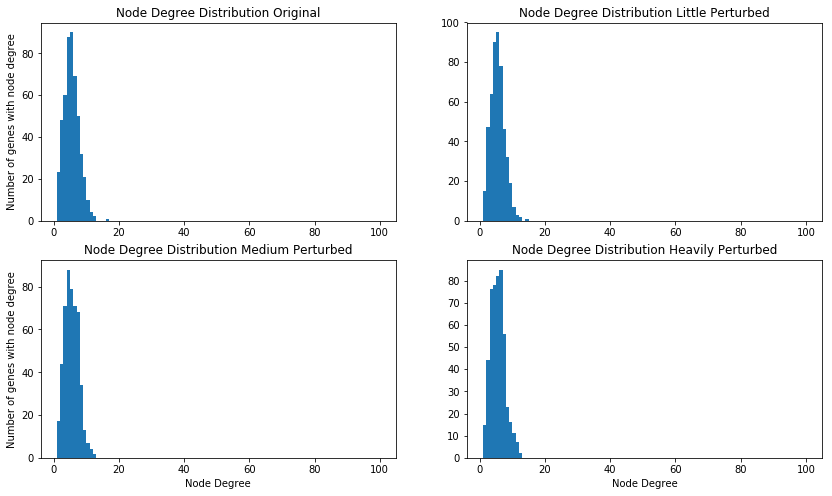

In [35]:
# plot node degree to check if distribution follows power law
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(1, 100, 100)

plt.subplot(2, 2, 1)
ax = plt.hist(ppi.sum(axis=0), bins)
#plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution Original')

plt.subplot(2, 2, 2)
ax = plt.hist(ppi_little_perturbed.sum(axis=0), bins)
#plt.xlabel('Node Degree')
#plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution Little Perturbed')
              
plt.subplot(2, 2, 3)
ax = plt.hist(ppi_medium_perturbed.sum(axis=0), bins)
plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution Medium Perturbed')

plt.subplot(2, 2, 4)
ax = plt.hist(ppi_largely_perturbed.sum(axis=0), bins)
plt.xlabel('Node Degree')
#plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution Heavily Perturbed')

## 3. Get Labels
The positives can come from the list of Vogelstein et al. while the negatives can be those genes not present in OMIM, not in the list of Vogelstein and with a low score in COSMIC.

In [11]:
cancer_gene_list = pd.read_csv('../data/cancer/vogelstein/table_s2a.csv', sep='\t', header=0)
print ("Got {} cancer genes".format(cancer_gene_list.shape[0]))
cancer_gene_list.columns = [i.strip('*') for i in cancer_gene_list.columns]
cancer_genes = cancer_gene_list[cancer_gene_list['Gene Symbol'].isin(node_list.name)]
oncogenes = cancer_genes[cancer_genes.Classification == "Oncogene"]
suppressors = cancer_genes[cancer_genes.Classification == "TSG"]
print ("Got {} oncogenes and {} tumour suppressors".format(oncogenes.shape[0], suppressors.shape[0]))

Got 125 cancer genes
Got 52 oncogenes and 71 tumour suppressors


In [36]:
#cancer_gene_list.head(10)

In [13]:
# get rid of the vogelstein cancer genes
not_positives = node_list[~node_list.name.isin(cancer_gene_list['Gene Symbol'])]
print ("{} genes are in network but not in Vogelstein list (oncogenes)".format(not_positives.shape[0]))

# get rid of the OMIM disease genes
omim_genes = pd.read_csv('../data/cancer/OMIM/genemap2.txt', sep='\t', comment='#', header=None)
omim_genes.columns = ['Chromosome', 'Genomic Position Start', 'Genomic Position End', 'Cyto Location',
                      'Computed Cyto Location', 'Mim Number', 'Gene Symbol', 'Gene Name',
                      'Approved Symbol', 'Entrez Gene ID', 'Ensembl Gene ID', 'Comments',
                      'Phenotypes', 'Mouse Gene Symbol/ID']
omim_gene_names = []
for idx, row in omim_genes.iterrows():
    gene_names = row['Gene Symbol'].strip().split(',')
    omim_gene_names += gene_names
omim_gene_names = list(set(omim_gene_names))
not_omim_not_pos = not_positives[~not_positives.name.isin(omim_gene_names)]
print ("{} genes are in network but not in oncogenes and not in OMIM".format(not_omim_not_pos.shape[0]))

# get rid of genes that are not in COSMIC
cosmic_gene_scores = pd.read_csv('../data/cancer/cosmic/cancer_gene_census.csv', header=0)
negatives = not_omim_not_pos[~not_omim_not_pos.name.isin(cosmic_gene_scores['Gene Symbol'])]
print ("{} genes in network but not in oncogenes, OMIM and COSMIC cancer gene census.".format(negatives.shape[0]))

12006 genes are in network but not in Vogelstein list (oncogenes)
2300 genes are in network but not in oncogenes and not in OMIM
2257 genes in network but not in oncogenes, OMIM and COSMIC cancer gene census.


## 3. Train / Test Split

In [14]:
def build_mask(nodes_with_labels, X):
    mask = np.array(nodes_with_labels.name.isin(X.name), dtype=np.uint8)
    # verify that all nodes from mask are in X and vice versa
    t = nodes_with_labels[mask.astype(bool)] # df for the mask
    assert (np.all(t.name.isin(X.name)) and np.all(X.name.isin(t.name)))
    return mask

def build_y(nodes_with_labels, X):
    y_t = np.array([node_list.name.isin(X.name) & node_list.cancer_gene], dtype=np.uint8).T
    return y_t

def balanced_stratified_split(X, test_ratio):
    # calculate number of labels for both sets
    num_labels_total = X.label.sum()
    num_labels_train = int(num_labels_total * (1-test_ratio))
    num_labels_test = num_labels_total - num_labels_train
    num_positives = X.cancer_gene.sum()
    num_pos_train = int(num_positives*(1-test_ratio))
    num_pos_test = num_positives - num_pos_train
    # select random training set (size 2*num_labels_train)
    X_train = X[X.cancer_gene].sample(n=num_pos_train)
    X_train = X_train.append(X[X.non_cancer_gene].sample(n=num_pos_train))
    # rest is test
    X_test = X[X.label & ~X.index.isin(X_train.index)]
    return X_train, X_test

In [16]:
# add columns for positives and negatives
node_list = pd.DataFrame(nx.to_pandas_adjacency(G).index, columns=['name'])
node_list['cancer_gene'] = node_list.name.isin(cancer_gene_list['Gene Symbol'])
node_list['non_cancer_gene'] = node_list.name.isin(negatives.name)
# add column for label in general
node_list['label'] = node_list.cancer_gene | node_list.non_cancer_gene
# assert that labels are set correctly
assert (node_list[node_list.cancer_gene | node_list.non_cancer_gene].equals(node_list[node_list.label]))

# split for training, testing & validation
if BALANCE:
    X_train, X_test = balanced_stratified_split(node_list, TEST_RATIO)
else:
    X_train, X_test = train_test_split(node_list[node_list.label],
                                       test_size=TEST_RATIO,
                                       stratify=node_list[node_list.label].cancer_gene
                                      )
if VAL_SIZE > 0:
    X_val = X_train[-VAL_SIZE:]
    X_train = X_train[:-VAL_SIZE]
else:
    X_val = None
print ("Split Training and Testing with {}% test nodes".format(TEST_RATIO*100.))
print ("Training Nodes: {}\t#Positive Genes in Train Set: {}".format(X_train.shape[0],
                                                                 X_train.cancer_gene.sum())
      )
print ("Testing Nodes: {}\t#Positive Genes in Test Set: {}".format(X_test.shape[0],
                                                               X_test.cancer_gene.sum())
      )

# construct masks
train_mask = build_mask(node_list, X_train)
test_mask = build_mask(node_list, X_test)
if X_val is not None:
    val_mask = build_mask(node_list, X_val)

# construct labels
y_train = build_y(node_list, X_train)
y_test = build_y(node_list, X_test)
if X_val is not None:
    y_val = build_y(node_list, X_val)

Split Training and Testing with 40.0% test nodes
Training Nodes: 1428	#Positive Genes in Train Set: 74
Testing Nodes: 952	#Positive Genes in Test Set: 49


## 4. Get Ensembl IDs for Gene Names

In [17]:
# get Ensembl IDs for gene names
mg = mygene.MyGeneInfo()
res = mg.querymany(node_list.name,
                   scopes='symbol, refseq, uniprot',
                   fields='ensembl.gene',
                   species='human', returnall=True
                  )

# now, retrieve the names and IDs from a dictionary and put in DF
def get_name_and_id(x):
    ens_id = x['ensembl'][0]['gene'] if type(x['ensembl']) is list else x['ensembl']['gene']
    name = x['query']
    return [name, ens_id]

ens_ids = [get_name_and_id(x) for x in res['out'] if 'ensembl' in x]
node_names_ids = pd.DataFrame(ens_ids, columns=['name', 'ID'])
node_names_ids.set_index('name', inplace=True)
node_names_ids = node_names_ids[~node_names_ids.index.duplicated(keep='first')]

# join with node list to have the correct order and derive gene names
nodes_with_ids = node_list.join(node_names_ids, on='name')
nodes_with_ids.loc[nodes_with_ids.ID.isnull(), 'ID'] = nodes_with_ids[nodes_with_ids.ID.isnull()].name
gene_names = np.vstack((np.array(nodes_with_ids.ID), np.array(nodes_with_ids.name))).transpose(1, 0)

print ("{} gene names (symbols) mapped successfully".format(len(ens_ids)))

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-12129...done.
Finished.
32 input query terms found dup hits:
	[('FCN1', 2), ('RPS27', 2), ('DNAJB3', 2), ('RMI2', 2), ('SGCZ', 2), ('SRD5A1', 2), ('CCL27', 2), ('
633 input query terms found no hit:
	['TCEB3C', 'C12orf44', 'HMP19', 'BZRAP1', 'LECT1', 'C1orf182', 'KIAA0226L', 'GCET2', 'C12orf12', 'SE
11504 gene names (symbols) mapped successfully


## 5. Save To hdf5

In [228]:
ppi_network = nx.to_numpy_array(G)
# test if ppi_network (A) has the same degree as the graph
# this should test if the features have the same ordering as the network
assert (np.all(np.equal(ppi_network.sum(axis=0), np.array([d[1] for d in list(nx.degree(G))]))))

# only one dim output (not one-hot)
#y_train = np.array([y_train[:, 0]]).T
#y_test = np.array([y_test[:, 0]]).T
#if X_val is not None:
#    y_val = np.array([y_val[:, 0]]).T

# build feature vector
node_index = nx.to_pandas_adjacency(G).index
if USE_HEAT_SCORES:
    attributes = nx.get_node_attributes(G, 'heat')
    features = np.array([[attributes[i] for i in node_index]]).T
else:
    attributes = nx.get_node_attributes(G, 'features')
    features = np.array([attributes[i] for i in node_index])

# create gene names
string_dt = h5py.special_dtype(vlen=str)

# determine file name by parameters
b = 'balanced' if BALANCE else 'unbalanced'
f = 'heat' if USE_HEAT_SCORES else 'vec'
fname = '../data/cancer/hotnet_iref_{}_input_{}.h5'.format(f, b)
f = h5py.File(fname, 'w')

# add ppi network
f.create_dataset('network', data=ppi_network, shape=ppi_network.shape)
# add features
f.create_dataset('features', data=features, shape=features.shape)
# add gene names (same order as features & network)
f.create_dataset('gene_names', data=gene_names, dtype=string_dt)
# add labels
f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
if X_val is not None:
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)

f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
if X_val is not None:
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
f.close()
print ("Container written to {}".format(fname))

Container written to ../data/cancer/hotnet_iref_vec_input_unbalanced.h5


In [59]:
assert (np.alltrue([gene_names[i] == node_index[i] for i in range(node_index.shape[0])]))